# IMDB Rating Prediction Using Ridge Regression

## 1. Importing Required Libraries

We begin by importing all the libraries needed for data handling, feature engineering, and model building.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

## 2. Defining Constant Threshold Values

These values help filter noisy samples and stabilize the smoothing encodings.

In [116]:
MIN_VOTES = 100
MIN_RUNTIME = 60
SMOOTH_FACTOR = 5

## 3. Loading and Cleaning the Dataset

The dataset is loaded and cleaned based on vote count and runtime thresholds.

In [117]:
df = pd.read_csv('IMDB_cleaned.csv')

df = df[df['votes'] > MIN_VOTES]
df = df[df['runtime'] >= MIN_RUNTIME]
print(f"Number of films after filtering: {len(df)}")

Number of films after filtering: 39238


## 4. Feature Engineering: Log Transform and Genre Encoding

Log-transform votes and convert multi-genre strings into binary columns.

In [118]:
df['log_votes'] = np.log1p(df['votes'])

df['genre'] = df['genre'].str.replace(' ', '')
genres_encoded = df['genre'].str.get_dummies(sep=',')

## 5. Feature–Target Separation

We prepare our feature matrix and target vector.

In [119]:
X = pd.concat([df[['log_votes', 'runtime', 'director', 'stars']], genres_encoded], axis=1)
y = df['rating']

## 6. Train–Test Split

Separate the dataset into training and test subsets.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 7. Feature Engineering: Cast Score Computation

This step assigns each actor a smoothed rating based on the movies they appear in.

### 7.1 Actor Score Calculation Function

In [121]:
def calculate_actor_scores(train_df, m):
    exploded = train_df.assign(actor=train_df['stars'].str.split(',')).explode('actor')
    exploded['actor'] = exploded['actor'].str.strip()

    global_mean = train_df['rating'].mean()
    agg = exploded.groupby('actor')['rating'].agg(['count', 'mean'])

    counts = agg['count']
    means = agg['mean']

    actor_score_map = (counts * means + m * global_mean) / (counts + m)
    return actor_score_map, global_mean

Explanation:

* Each movie’s cast list is split and expanded into multiple rows
* Each actor receives a smoothed score
* This prevents actors with few appearances from having extreme values

### 7.2 Adding Cast Score to Dataset

In [122]:
def get_average_cast_score(df_target, score_map, global_val):
    exploded = df_target.assign(actor=df_target['stars'].str.split(',')).explode('actor')
    exploded['actor'] = exploded['actor'].str.strip()

    exploded['actor_score'] = exploded['actor'].map(score_map).fillna(global_val)
    avg_scores = exploded.groupby(exploded.index)['actor_score'].mean()

    return avg_scores

### 7.3 Applying Cast Scores to Train and Test Sets

The cast score is computed using only the training set and The stars column is removed since it’s no longer needed.

In [123]:
temp_train = X_train.copy()
temp_train['rating'] = y_train

actor_map, global_avg = calculate_actor_scores(temp_train, SMOOTH_FACTOR)

X_train['cast_score'] = get_average_cast_score(X_train, actor_map, global_avg)
X_test['cast_score'] = get_average_cast_score(X_test, actor_map, global_avg)

X_train = X_train.drop(columns=['stars'], errors='ignore')
X_test = X_test.drop(columns=['stars'], errors='ignore')

## 8. Director Smoothed Target Encoding

We encode directors similarly to actors, using smoothing to avoid overfitting.

### 8.1 Director Encoding Function

In [124]:
def smoothed_target_encoding(train_df, col_name, target_name, m):
    global_mean = train_df[target_name].mean()
    agg = train_df.groupby(col_name)[target_name].agg(['count', 'mean'])

    counts = agg['count']
    means = agg['mean']

    smooth = (counts * means + m * global_mean) / (counts + m)
    return smooth, global_mean

Explanation:
Directors with fewer movies get a smoothed score closer to the global mean.

### 8.2 Applying Director Encoding

The encoded director score is added as a numeric feature, and the original director names are dropped.

In [125]:
temp_train_data = X_train.copy()
temp_train_data['rating'] = y_train

dir_map, global_mean = smoothed_target_encoding(temp_train_data, 'director', 'rating', SMOOTH_FACTOR)
X_train['director_encoded'] = X_train['director'].map(dir_map).fillna(global_mean)
X_test['director_encoded'] = X_test['director'].map(dir_map).fillna(global_mean)

X_train = X_train.drop(columns=['director'])
X_test = X_test.drop(columns=['director'])

## 9. Build a Pipeline (Scaling + Ridge Regression)

Using a pipeline ensures the correct order of operations and prevents human error:

In [126]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

## 10. Hyperparameter Tuning (GridSearchCV)

Ridge regression has only one main hyperparameter (alpha), so a grid search is efficient.

In [127]:
params = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100, 1000]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=5,
    scoring="neg_mean_squared_error"
)

grid.fit(X_train, y_train)


,estimator,"Pipeline(step...e', Ridge())])"
,param_grid,"{'ridge__alpha': [0.01, 0.1, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


## 11. Best Model Results

In [128]:
best_alpha = grid.best_params_["ridge__alpha"]
print("Best alpha:", best_alpha)

Best alpha: 10


In [129]:
best_model = grid.best_estimator_

## 12. Model Evaluation

### 12.1 Predictions

In [130]:
y_pred = best_model.predict(X_test)

### 12.2 Performance Metrics

In [131]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nR2 Score: {r2:.4f}\nRMSE: {rmse:.4f}")


R2 Score: 0.4439
RMSE: 0.9780


## 13. Visualization of Results

### 13.1 Predicted vs Actual Scatter Plot

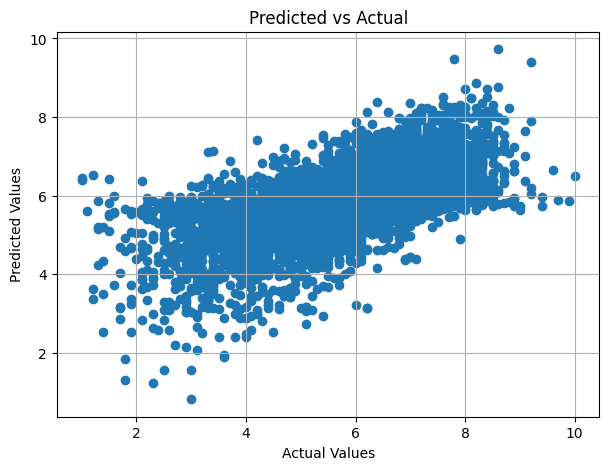

In [132]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

### 13.2 Residual Plot

Residuals help diagnose bias or non-linearity.

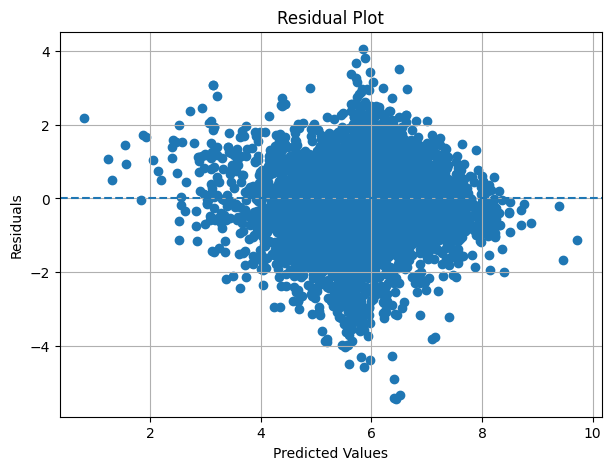

In [133]:
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

### 13.3 Error Distribution

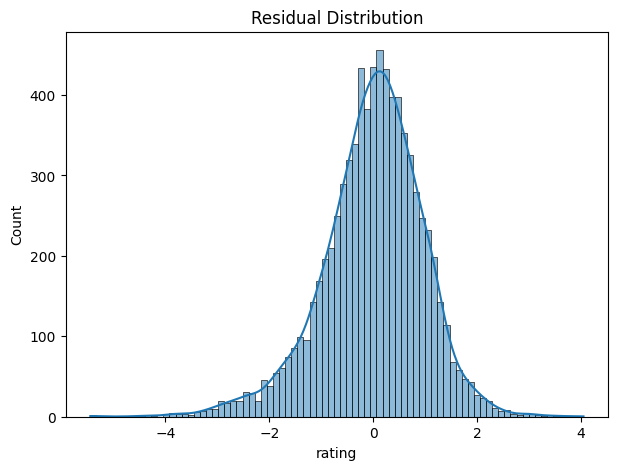

In [134]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()